# GANs

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [32]:
# imports

import sys
assert sys.version_info >= (3, 5)

# Scikit Learn
import sklearn
assert sklearn.__version__ >= "0.20"

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Check GPU availaility
physical_devices = tf.config.list_logical_devices('GPU')
print("Num Devices: ", len(physical_devices))

# common imports
import numpy as np
import os

# set random seeds
np.random.seed(42)
tf.random.set_seed(42)

import matplotlib.pyplot as plt
import matplotlib as mpl

Num Devices:  0


## PCA with a Linear Autoencoder

Synthetic 3D Dataset

In [0]:
# utility function to plot images

def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')

In [0]:
# helper function to create 3D dataset

np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

In [5]:
X_train = generate_3d_data(60)
X_train.shape

(60, 3)

In [0]:
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [0]:
from mpl_toolkits import mplot3d

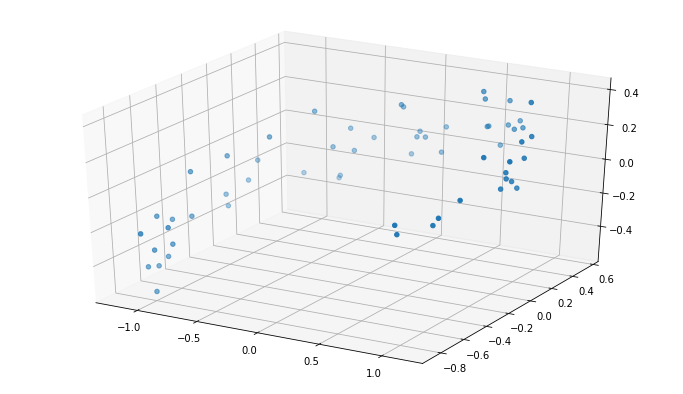

In [8]:
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection='3d')

ax.scatter3D(X_train[:, 0], X_train[:, 1], X_train[:, 2])

## Simple Autoencoder

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2, input_shape=[3])
])

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(3, input_shape=[2])
])

autoencoder = tf.keras.Sequential([
                encoder, decoder
])

autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 2)                 8         
_________________________________________________________________
sequential_1 (Sequential)    (None, 3)                 9         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [0]:
# compile model

optimizer = tf.keras.optimizers.SGD(learning_rate=1.5)

autoencoder.compile(loss='mse', optimizer=optimizer)

In [11]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Train on 60 samples
Epoch 1/20
60/60 [==============================] - 0s 7ms/sample - loss: 0.3064
Epoch 2/20
60/60 [==============================] - 0s 160us/sample - loss: 0.3797
Epoch 3/20
60/60 [==============================] - 0s 162us/sample - loss: 0.1454
Epoch 4/20
60/60 [==============================] - 0s 190us/sample - loss: 0.0872
Epoch 5/20
60/60 [==============================] - 0s 136us/sample - loss: 0.0658
Epoch 6/20
60/60 [==============================] - 0s 90us/sample - loss: 0.0464
Epoch 7/20
60/60 [==============================] - 0s 97us/sample - loss: 0.0356
Epoch 8/20
60/60 [==============================] - 0s 101us/sample - loss: 0.0238
Epoch 9/20
60/60 [==============================] - 0s 92us/sample - loss: 0.0225
Epoch 10/20
60/60 [==============================] - 0s 99us/sample - loss: 0.0093
Epoch 11/20
60/60 [==============================] - 0s 90us/sample - loss: 0.0068
Epoch 12/20
60/60 [==============================] - 0s 95us/sample - lo

In [12]:
codings = encoder.predict(X_train)
codings.shape

(60, 2)

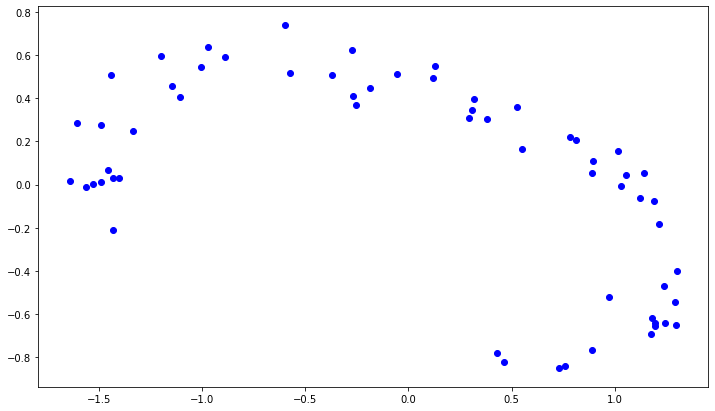

In [13]:
# plot codings
plt.figure(figsize=(12, 7))
plt.scatter(codings[:, 0], codings[:, 1], marker='o', c='b')

## Stacked Autoencoders

### MNIST

In [14]:
# load mnist data

(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

X_train_full = X_train_full.astype(np.float32) / 255.
X_test = X_test.astype(np.float32)/255.

4423680/4422102 [==============================] - 0s 0us/step


In [15]:
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train.shape, y_train.shape

((55000, 28, 28), (55000,))

### Autoencoder model

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Reshape

In [0]:
# custom metric

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

# Stacked Encoder
stacked_encoder = Sequential([
        Flatten(input_shape=[28, 28]),
        Dense(100, activation='selu'),
        Dense(30, activation='selu')
])

# Stacked Decoder
stacked_decoder = Sequential([
        Dense(100, activation='selu', input_shape=[30]),
        Dense(28*28, activation='sigmoid'),
        Reshape([28, 28])
])

# Autoencoder
stacked_ae = Sequential([stacked_encoder, stacked_decoder])

In [0]:
# compile
stacked_ae.compile(loss='binary_crossentropy',
                   optimizer = tf.keras.optimizers.SGD(learning_rate=1.5),
                   metrics=[rounded_accuracy])

In [20]:
# fit model

history = stacked_ae.fit(x=X_train, y=X_train, epochs=20,
                         validation_data = [X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 9s 155us/sample - loss: 0.3390 - rounded_accuracy: 0.8860 - val_loss: 0.3111 - val_rounded_accuracy: 0.9129
Epoch 2/20
55000/55000 [==============================] - 8s 144us/sample - loss: 0.3059 - rounded_accuracy: 0.9149 - val_loss: 0.3047 - val_rounded_accuracy: 0.9201
Epoch 3/20
55000/55000 [==============================] - 8s 147us/sample - loss: 0.2989 - rounded_accuracy: 0.9212 - val_loss: 0.3032 - val_rounded_accuracy: 0.9121
Epoch 4/20
55000/55000 [==============================] - 8s 141us/sample - loss: 0.2950 - rounded_accuracy: 0.9246 - val_loss: 0.2944 - val_rounded_accuracy: 0.9277
Epoch 5/20
55000/55000 [==============================] - 8s 143us/sample - loss: 0.2925 - rounded_accuracy: 0.9268 - val_loss: 0.2924 - val_rounded_accuracy: 0.9276
Epoch 6/20
55000/55000 [==============================] - 8s 144us/sample - loss: 0.2908 - rounded_accuracy: 0.9281 - val

### Reconstructions

In [0]:
# helper function to compare originals to reconstructions

def show_reconstructions(model, images=X_valid, n_images=8):
    reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

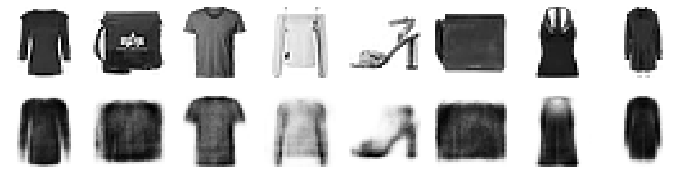

In [22]:
show_reconstructions(stacked_ae)

## Visualise MNIST with t-SNE

In [0]:
np.random.seed(42)

from sklearn.manifold import TSNE

In [0]:
# run data through stacked_encoder

X_valid_compressed = stacked_encoder.predict(X_valid)

tsne = TSNE() # default parameters

In [0]:
X_valid_2D = tsne.fit_transform(X_valid_compressed)
# standardise
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

In [27]:
X_valid_2D.shape

(5000, 2)

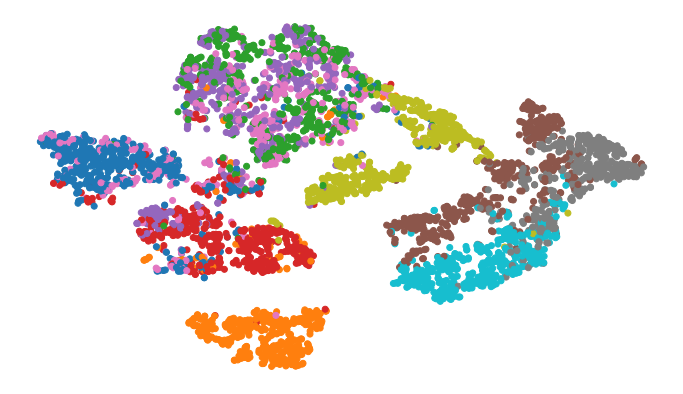

In [31]:
# plot
plt.figure(figsize=(12,7))
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, cmap='tab10')
plt.axis('off');

(-0.05128109939199297,
 1.0525347669123521,
 -0.0465969706702422,
 0.9145462180304719)

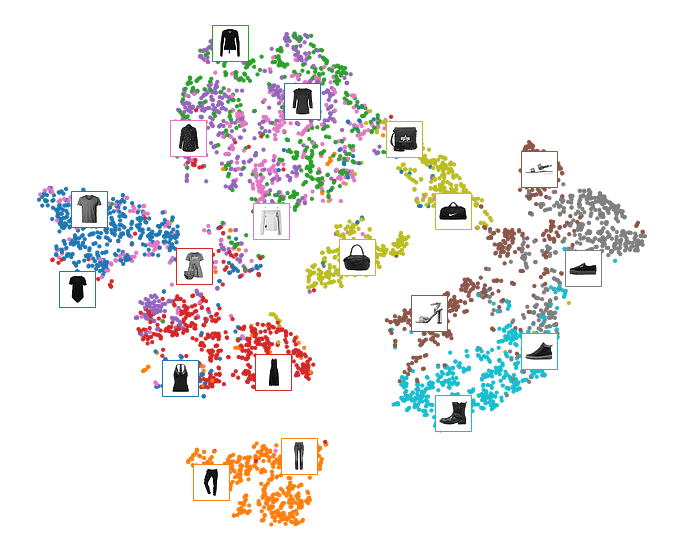

In [34]:
# https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html

plt.figure(figsize=(12, 10))
cmap = plt.cm.tab10

plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c = y_valid,
            cmap=cmap, s=10)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    # calculate distance
    dist = np.sum((position - image_positions)**2, axis=1)
    if np.min(dist) > 0.02: 
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap='binary'),
            position, bboxprops={'edgecolor': cmap(y_valid[index]), "lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis('off')